<a href="https://colab.research.google.com/github/rpatel71/Design-Optimization/blob/main/Homework_5/hw5_sqp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing all the libraries
import numpy as np
from matplotlib import pyplot as plt
import torch as t

In [2]:
# defining the objective function as well as inequality constraints
function = lambda x: x[0]**2 + (x[1] - 3)**2
g_1 = lambda x: x[1]**2 - 2*x[0]
g_2 = lambda x: (x[1]-1)**2 + 5*x[0]-15
grad_fun  = lambda x : t.tensor([[2 * x[0], 2 * (x[1] - 3)]])
grad_g_1 = lambda x : t.tensor([[-2, 2 * x[1]]])
grad_g_2 = lambda x: t.tensor([[5, 2 * (x[1] - 1)]])

In [3]:
# function for updating weights for the merit function
def update_weights(lam, w, k):
  if k > 0:
    w = t.max(abs(lam), 0.5 *(w + abs(lam)))
  else:
    w = abs(lam)
  return w

# function which calculates F(alpha)
def fun_alp(x,w,alpha,s):
  new_fun = function(x + alpha*s) +  w[0,:] * max(0, g_1(x + alpha*s)) + w[1,:]* max(0, g_2(x + alpha*s))
  return new_fun

In [4]:
# function for calculating the armijo linesearch algorithm
def line_Search(x,lam,w,s,k):
    t_t = 0.2
    alpha = 1
    w = update_weights(lam, w,k)
    if g_1(x) <= 0:
       Dg1Da = 0
    else:
      Dg1Da= t.matmul(grad_g_1(x), s)

    if g_2(x) <= 0:
       Dg2Da = 0
    else:
      Dg2Da= t.matmul(grad_g_2(x), s)

    dfun_da = t.matmul(grad_fun(x), s) + (w[0, :] * Dg1Da + w[1, :] * Dg2Da)

    phi = lambda x, w, alpha, t_t, dfun_da: fun_alp(x, w, 0, 0) + alpha * t_t * dfun_da

    while phi(x, w, alpha, t_t, dfun_da) < fun_alp(x, w, alpha, s):
        alpha = 0.5 * alpha
    return alpha, w

In [5]:
# function for approximating the Hessian via Broyden-Fletcher-Goldfarb-Shanno(BFGS) Method
def bfgs(x,Lxx, s, lam, alpha):
  grad_l_k = grad_fun(x) + t.matmul(lam.T, t.tensor([g_1(x),g_2(x)]))
  grad_l_kp1 = grad_fun(x + alpha*s) + t.matmul(lam.T, t.tensor([g_1(x + alpha*s),g_2(x + alpha*s )]))

  delta_l = grad_l_kp1 -grad_l_k
  
  Q = t.matmul(t.matmul((alpha*s).T, Lxx), (alpha*s))
  if t.matmul((alpha*s).T, delta_l.T) >= 0.2 * t.matmul(t.matmul((alpha*s).T, Lxx), (alpha*s)):
        th = 1
  else:
        th = 0.8 * Q / (Q - t.matmul((alpha*s).T, delta_l.T))
  y = th * delta_l.T + (1 - th) * t.matmul(Lxx, (alpha*s))
  Lxx = Lxx + t.matmul(y, y.T) / t.matmul(y.T, s) - t.matmul(t.matmul(Lxx, s), t.matmul(s.T, Lxx)) / t.matmul(t.matmul(s.T, Lxx), s)
  return Lxx

In [6]:
def check_lag_multiplier(lam,active_set):
    lam_check = 0
    if len(lam) == 0 or min(lam) > 0:
        lam_check  = 1
    else:
        lam_idx = np.argmin(np.array(lam))
        lam = lam[lam!=min(lam)]
        active_set.pop(lam_idx)
    return active_set, lam_check ,lam

In [7]:
# function to solve the qp subproblem
def sol_qp(x, Lxx):
    active_set = []
    init_A = t.cat((grad_g_1(x),grad_g_2(x)),0)
    init_B=t.tensor([[g_1(x), g_2(x)]]).T
    init_lam = t.zeros((init_B.shape[0], 1))
    lam = []
    while True:
      if len(active_set) == 0:
            s_lam = t.matmul(t.linalg.inv(Lxx), -grad_fun(x).T)
            s = s_lam[:2, :]
      if len(active_set) > 0:
        if len(active_set) == 1:
                A = init_A[active_set[0], :].reshape(1, -1)
                B = init_B[active_set[0], :].reshape(1,1)
        if len(active_set) == 2:
                A = init_A
                B = init_B
                
        Z = t.zeros((A.shape[0], A.shape[0]))
        matrix=t.cat((t.cat((Lxx,A.T),1),t.cat((A,Z),1)),0)
        j=t.cat((-grad_fun(x).T,-B),0)
        s_lam = t.matmul(t.linalg.inv(matrix), j)
        s = s_lam[:2, :]
        lam = s_lam[2:, :]

      if len(lam) == 1:
          init_lam[0] = s_lam[2:3, :]
      if len(lam) == 2:
          init_lam[0] = s_lam[2:3, :]
          init_lam[1] = s_lam[3:, :]

      const_sqp = t.round((t.matmul(init_A, s.reshape(-1, 1)) + init_B))
      active_set, check_mu,lam = check_lag_multiplier(lam,active_set)

      if t.max(const_sqp) <= 0 and check_mu == 1:
            return s, init_lam
      else:
          index = np.argmax(const_sqp)
          active_set.append(index)
          active_set = np.unique(np.array(active_set)).tolist()

In [8]:
x = t.tensor([[1,1.]]).T
init_x = x
lam = t.zeros((x.shape[0], 1))
w = t.zeros((x.shape[0], 1))+2
Lxx = t.eye(x.shape[0])
eps = 1e-4
k = 0

norm_delt_L = np.linalg.norm(grad_fun(x) + np.matmul(lam.T, t.cat((grad_g_1(x),grad_g_2(x)),0)))

while norm_delt_L > eps:
    s, lam = sol_qp(x, Lxx)
    alpha, w = line_Search(x,lam,w,s,k)
    Lxx = bfgs(x,Lxx, s, lam, alpha) 
    x += alpha*s
    k += 1
    norm_delt_L = np.linalg.norm(grad_fun(x) + np.matmul(lam.T, t.cat((grad_g_1(x),grad_g_2(x)),0)))

In [9]:
print(f'The solution X is = ({x[0][0]}, {x[1][0]})')

The solution X is = (1.0601987838745117, 1.4561585187911987)


In [10]:
print(f"objective function's minimum value is: {function([x[0][0],x[1][0]])}")
print(f"The value of inequality constraints is given as:   g1 = {g_1([x[0][0],x[1][0]])},      g2 = {g_2([x[0][0],x[1][0]])}")

objective function's minimum value is: 3.507467746734619
The value of inequality constraints is given as:   g1 = 0.0,      g2 = -9.490924835205078


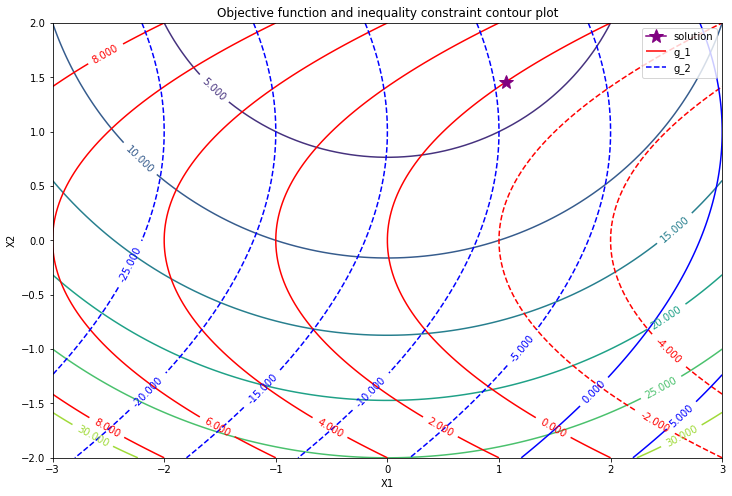

In [11]:
X1 = np.linspace(-3, 3, 100)
X2 = np.linspace(-2, 2, 100)

# Here, we want a grid of the size given above, X1 and X2 are cartesian coordinates

param_grid = np.array([[x1, x2] for x2 in X2 for x1 in X1])
real = [function(params) for params in param_grid]
real_g1 = [g_1(params) for params in param_grid]
real_g2 = [g_2(params) for params in param_grid]

x1, x2 = np.meshgrid(X1, X2)
fig, ax = plt.subplots(figsize=(12,8))
Con_P = ax.contour(x1, x2, np.array(real).reshape(x1.shape))
ax.clabel(Con_P, inline=True, fontsize=10)

Con_P1 = ax.contour(x1, x2, np.array(real_g1).reshape(x1.shape), colors='r')
Con_P1.collections[-1].set_label("g_1")
ax.clabel(Con_P1, inline=True, fontsize=10)

Con_P2 = ax.contour(x1, x2, np.array(real_g2).reshape(x1.shape), colors='b')
Con_P2.collections[1].set_label("g_2")
ax.clabel(Con_P2, inline=True, fontsize=10)

plt.plot(x[0], x[1], c='purple', marker='*', markersize='15', label='solution')
plt.xlabel("X1", fontsize=10)
plt.ylabel("X2", fontsize=10)
plt.legend()
plt.title('Objective function and inequality constraint contour plot')
ax.legend(loc='best')
plt.show()